# 参考
https://tkstock.site/2018/06/12/post-402/

In [2]:
import pandas as pd
from pycoingecko import CoinGeckoAPI
import matplotlib.pyplot as plt
import time
import concurrent.futures

## ユニバースを定義する
Coincheckで購入可能なコインのみ

In [3]:
universe_list = pd.read_excel("../data/universe.xlsx")
universe_list = list(universe_list["ID"])
universe_list[:5]

['bitcoin', 'ethereum', 'ethereum-classic', 'lisk', 'ripple']

## CoinGechoから仮想通貨の情報を取得する

In [4]:
# CoinGecko APIクライアントを作成
cg = CoinGeckoAPI()

# 仮想通貨リストを取得
coin_list = cg.get_coins_list()
coin_list_df = pd.DataFrame(coin_list)
coin_list_df.head()

,id,symbol,name
0,01coin,zoc,01coin
1,0chain,zcn,Zus
2,0dog,0dog,Bitcoin Dogs
3,0-knowledge-network,0kn,0 Knowledge Network
4,0-mee,ome,O-MEE


In [5]:
# ユニバースのコインのみ抽出
filtered_df = coin_list_df[coin_list_df["id"].isin(universe_list)]
filtered_df.reset_index(inplace = True, drop = True)
filtered_df.head()

,id,symbol,name
0,avalanche-2,avax,Avalanche
1,bitcoin,btc,Bitcoin
2,bitcoin-cash,bch,Bitcoin Cash
3,blood-crystal,bc,Blood Crystal
4,bridged-wbtc,wbtc,Bridged WBTC


In [7]:
def get_specific_coin_data(coin_id, currency, days):
    """指定されたコインのデータを取得する関数"""
    return cg.get_coin_market_chart_by_id(id=coin_id, vs_currency=currency, days=days)

def fetch_coin_data_with_timeout(row, timeout=5):
    """タイムアウト付きでコインデータを取得する"""
    coin_id = row["id"]
    currency = "jpy"
    days = "365"

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future = executor.submit(get_specific_coin_data, coin_id, currency, days)
        try:
            return future.result(timeout=timeout)  # タイムアウトを設定
        except concurrent.futures.TimeoutError:
            print(f"処理がタイムアウトしました: {coin_id}")
            return None

# コインデータを格納するDataFrame
all_coin_df = pd.DataFrame([])

for i in range(len(filtered_df)):
    specific_coin_data_input = filtered_df.iloc[i]

    # タイムアウト付きでデータ取得
    specific_coin_data = fetch_coin_data_with_timeout(specific_coin_data_input, timeout=5)

    if specific_coin_data:
        # 必要な処理に応じてデータを整形して追加
        coin_data_df = pd.DataFrame(specific_coin_data['prices'], columns=["timestamp", "price"])

        # 列名を変える
        new_col_name = specific_coin_data_input["name"] + "_price"
        coin_data_df.rename({"price": new_col_name}, inplace=True, axis = 1)

        # 横結合
        if i == 0:
            all_coin_df = coin_data_df
        else:
            all_coin_df = pd.merge(all_coin_df, coin_data_df, on = "timestamp", how = "outer")

    time.sleep(30)  # APIの呼び出し間隔を調整


In [8]:
from datetime import datetime

def unix_millis_to_datetime(unix_millis):
    # UNIXミリ秒を秒に変換
    unix_seconds = unix_millis / 1000.0
    
    # datetimeオブジェクトに変換
    dt_object = datetime.utcfromtimestamp(unix_seconds)
    
    return dt_object

In [9]:
all_coin_df["timestamp"] = all_coin_df["timestamp"].map(unix_millis_to_datetime)

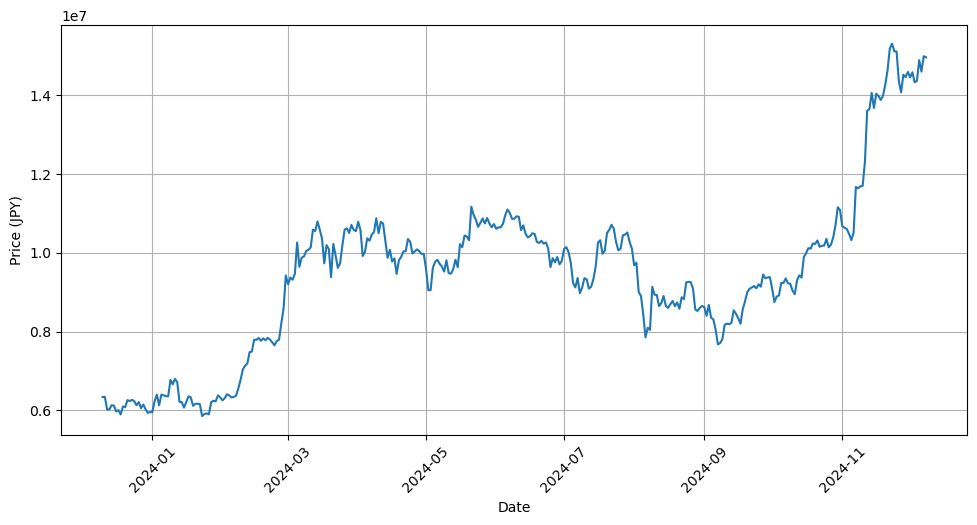

In [10]:
plt.figure(figsize=(10, 5))
plt.xlabel("Date")
plt.ylabel("Price (JPY)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.plot(all_coin_df[["timestamp"]], all_coin_df[["Bitcoin_price"]])
plt.show()

In [18]:
all_coin_df.to_csv("../data/price_data.csv")